Записки психа))
составим план

   построить простейшую линейную модель с минимальной предобработкой и без генерации фичей, потом от этого плясать...
   было бы неплохо все же коммитить каждую версию тетрадки, чтобы не потерять результаты и не6 забыть метрики, возможно стоит создать сводную таблицу с версией тетрадки и какую метрику она дала, чтобы было проще откатиться сразу на нужный коммит...
   опробовать нормализацию библиотеки adjdatatools...
   не забыться поиграть с понижением размерности и tSNE? чтобы добавить фичу по кластеру...
   провести тщательный EDA...
   
Цель - f-score выше 0.66)))))

# Оглавление

#### 1. Импорт библиотек и оптимизация памяти
#### 2. EDA
#### 3. Обрабртка выбросов
#### 4. Заполнение пропусков
#### 5. Генерация новых признаков
#### 6. Отбор признаков
#### 7. Построение модели
#### 8. Предсказание на тесте

## 1. Импорт библиотек и оптимизация памяти

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)
from scipy.stats import shapiro, probplot, mannwhitneyu, chi2_contingency

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler

from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
matplotlib.rcParams.update({'font.size': 10})

In [3]:
import warnings
warnings.filterwarnings('ignore')

Загрузим данные соревнования с Kaggle

In [4]:
api = KaggleApi()
api.authenticate()
api.competition_download_files('gb-credit-default')

In [5]:
dataset_zip = zipfile.ZipFile('./gb-credit-default.zip')
dataset_zip.extractall()

Прописываем пути к данным

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = './sample_submission.csv'

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train F1:\t" + str(round(f1_score(train_true_values, train_pred_values), 4)))
    print("Test F1:\t" + str(round(f1_score(test_true_values, test_pred_values), 4)))

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [9]:
train_df.shape

(7500, 17)

In [10]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [12]:
test_df.head(7)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0


In [13]:
def int_to_str(X):
    
    col = ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']
    X[col] = X[col].astype(str)
    
    return X

## 2. EDA

In [14]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [16]:
def value_def(x):
    val_series = train_df[x].value_counts()
    return val_series

In [17]:
value_def('Home Ownership')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [18]:
value_def('Years in current job')

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [19]:
value_def('Tax Liens')

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [20]:
value_def('Number of Open Accounts')

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [21]:
value_def('Years of Credit History')

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

In [22]:
value_def('Months since last delinquent')

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [23]:
value_def('Number of Credit Problems')

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [24]:
value_def('Bankruptcies')

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [25]:
value_def('Purpose')

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [26]:
value_def('Term')

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [27]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

In [28]:
df_num_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,99999999.0,477812.0,12479.0,748.0
7498,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN


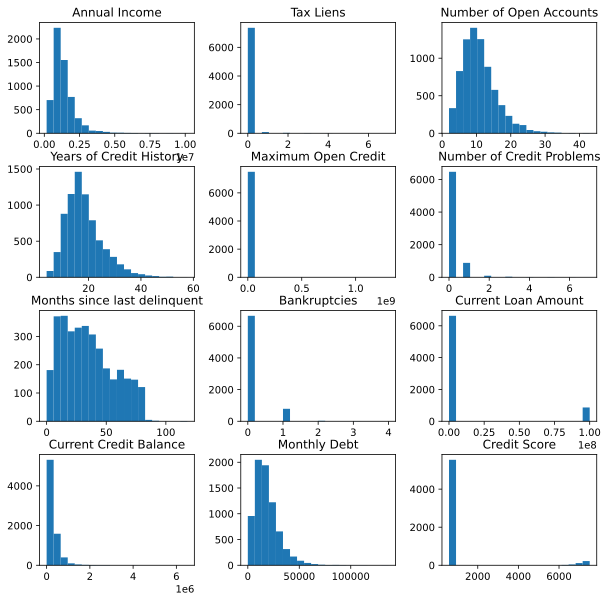

In [29]:
df_num_features.hist(figsize=(10,10), bins=20, grid=False);

In [30]:
TARGET_NAME = train_df['Credit Default']

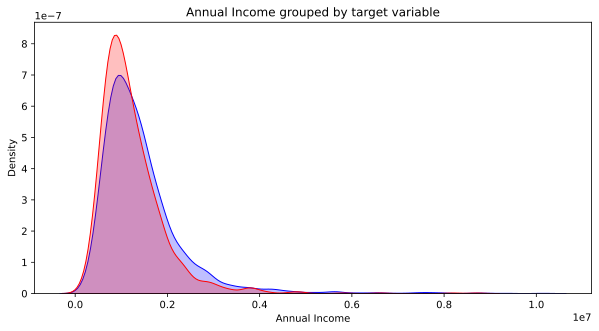

In [31]:
annual_income_with_target = train_df[['Annual Income', 'Credit Default']]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target['Credit Default'] == 0]
annual_income_target_1 = annual_income[annual_income_with_target['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='Нет просрочки', color='b')
sns.kdeplot(annual_income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

In [32]:
NUM_FEATURE_NAMES = ["', '".join(df_num_features.columns)]
NUM_FEATURE_NAMES

["Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score"]

In [33]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 
                     'Purpose', 'Term']

figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='b')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.yscale('log')
    plt.legend()
    plt.title(col)
    plt.show()

figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    feature_with_target = train_df[[col, 'Credit Default']]
    feature = feature_with_target[col]
    feature_target_0 = feature[feature_with_target['Credit Default'] == 0]
    feature_target_1 = feature[feature_with_target['Credit Default'] == 1]

    #plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_target_0, shade=True, label='Нет просрочки', color='b')
    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.yscale('log')
    plt.xlabel(col)
    plt.title('grouped by target variable')
    plt.show()

figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    feature_with_target = train_df[[col, 'Credit Default']]
    feature = feature_with_target[col]
    feature_target_0 = feature[feature_with_target['Credit Default'] == 0]
    feature_target_1 = feature[feature_with_target['Credit Default'] == 1]

    #plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_target_0, shade=True, label='Нет просрочки', color='b')
    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.xlabel(col)
    plt.title('grouped by target variable')
    plt.show()

In [34]:
train_df.loc[train_df['Credit Default'] == 1].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.584000e+03,2113.000000,2113.000000,2113.000000,2.113000e+03,2113.000000,983.000000,2109.000000,2113.000000,2.113000e+03,2113.000000,1584.000000,2113.0
mean,1.224243e+06,0.040700,11.357312,18.086228,5.798982e+05,0.185991,34.781282,0.118065,326651.044013,2.799256e+05,18666.352106,2327.548611,1.0
std,7.077733e+05,0.306572,4.996364,7.244804,5.517541e+05,0.542644,22.121493,0.354961,186027.080635,2.659432e+05,11947.197046,2787.985441,0.0
min,1.940280e+05,0.000000,2.000000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,1.0
25%,7.726730e+05,0.000000,8.000000,13.100000,2.562560e+05,0.000000,15.000000,0.000000,181610.000000,1.124610e+05,10534.000000,704.000000,1.0
50%,1.055916e+06,0.000000,11.000000,16.700000,4.420900e+05,0.000000,33.000000,0.000000,290576.000000,2.101020e+05,16390.000000,730.500000,1.0
75%,1.493894e+06,0.000000,14.000000,21.500000,7.279580e+05,0.000000,52.000000,0.000000,444708.000000,3.536470e+05,24057.000000,6162.500000,1.0
max,8.710740e+06,5.000000,42.000000,57.700000,6.639358e+06,5.000000,86.000000,4.000000,788634.000000,3.944514e+06,104036.000000,7510.000000,1.0


In [35]:
train_df.loc[train_df['Credit Default'] == 0].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5.387000e+03,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,2.937194e+05,18176.425469,723.577885,0.0
std,8.845096e+05,0.256502,4.871796,6.959349,1.890526e+07,0.480127,21.516233,0.344130,3.669223e+07,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,1.798060e+05,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,3.145340e+05,2.092850e+05,15939.000000,732.000000,0.0
75%,1.709572e+06,0.000000,14.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,5.510780e+05,3.629095e+05,23717.500000,742.000000,0.0
max,1.014934e+07,7.000000,43.000000,51.900000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,0.0


In [36]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [37]:
train_df.loc[(train_df['Credit Default'] == 0) | (train_df['Maximum Open Credit'] > 1000000000)].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5.387000e+03,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,2.937194e+05,18176.425469,723.577885,0.0
std,8.845096e+05,0.256502,4.871796,6.959349,1.890526e+07,0.480127,21.516233,0.344130,3.669223e+07,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,1.798060e+05,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,3.145340e+05,2.092850e+05,15939.000000,732.000000,0.0
75%,1.709572e+06,0.000000,14.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,5.510780e+05,3.629095e+05,23717.500000,742.000000,0.0
max,1.014934e+07,7.000000,43.000000,51.900000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,0.0


очень маленький уровень значимости по критерию Манна-Уитни у признаков Months since last delinquent, Bankruptcies, поэтому скорей всего на них обучать модель в конечном варианте не буду.
глядя на распределение целевой переменной, можно сделать вывод, что для некоторых признаков можно добавить категориальный признак: для Annual Income можно сделать разбивку на отметке около 8 720 000 (с запасом можно на 8 750 000);
для Tax Liens разбить < 6 и >=6;
для Years of Credit History разбить на отметке 52;
для MaximumOpen Credit разбить на отметке 6 700 000;
для Numbers of Credit Problem разбить на < 6 и >=6;
для Current Loan Amount разбить на отметке 790 000;
для Current Credit Ballance га отметке 4 000 000;
для Credit Score на отметке в 760.

In [38]:
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

In [39]:
train_df.loc[(train_df['Current Loan Amount']) > (train_df['Maximum Open Credit'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,Home Mortgage,1542952.0,10+ years,0.0,7.0,12.5,232364.0,0.0,59.0,0.0,debt consolidation,Long Term,267982.0,198873.0,15430.0,695.0,1
7488,Rent,465405.0,5 years,0.0,5.0,7.7,51744.0,0.0,33.0,0.0,home improvements,Short Term,129338.0,8721.0,13535.0,728.0,0
7491,Home Mortgage,2833185.0,6 years,0.0,18.0,21.3,280170.0,0.0,6.0,0.0,debt consolidation,Short Term,437404.0,108889.0,61150.0,704.0,0
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0


In [40]:
train_df.loc[(train_df['Current Loan Amount'] > 10000000) > (train_df['Maximum Open Credit'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
585,Home Mortgage,4772800.0,8 years,0.0,9.0,35.5,0.0,0.0,NaN,0.0,small business,Short Term,99999999.0,0.0,2227.0,747.0,0
602,Home Mortgage,5631030.0,1 year,0.0,5.0,17.5,0.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,60439.0,15485.0,743.0,0
1464,Home Mortgage,2432000.0,10+ years,0.0,7.0,21.1,0.0,0.0,NaN,0.0,business loan,Short Term,99999999.0,0.0,284.0,741.0,0
1984,Home Mortgage,8758449.0,10+ years,0.0,10.0,20.6,0.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,2759503.0,12919.0,748.0,0
2276,Rent,2086067.0,10+ years,0.0,6.0,20.3,0.0,0.0,8.0,0.0,debt consolidation,Long Term,99999999.0,0.0,28822.0,740.0,0
2297,Home Mortgage,1263785.0,8 years,0.0,12.0,16.8,0.0,0.0,12.0,0.0,buy a car,Short Term,99999999.0,0.0,30647.0,732.0,0
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,77.0,NaN,other,Short Term,99999999.0,0.0,1245.0,712.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,99999999.0,0.0,0.0,748.0,0
4962,Own Home,1893464.0,10+ years,0.0,8.0,20.7,0.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,69084.0,6864.0,751.0,0


In [41]:
train_df.loc[train_df['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,debt consolidation,Long Term,672078.0,19.0,8860.0,NaN,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,home improvements,Long Term,760452.0,0.0,36778.0,725.0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,small business,Long Term,751454.0,0.0,15348.0,737.0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


num_feature = 'Current Loan Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

## 3. Обрабртка выбросов

## 4. Заполнение пропусков

train_ann_income_med = train_df['Annual Income'].median()
train_years_job_mode = train_df['Years in current job'].mode()
train_delinquent_med = train_df['Months since last delinquent'].median()
train_bankruptcies_med = train_df['Bankruptcies'].median()
train_credit_score_med = train_df['Credit Score'].median()

train_df['Annual Income_nan'] = 0
train_df['Years in current job_nan'] = 0
train_df['Mounth since last delinquent_nan'] = 0
train_df['Credit Score_nan'] = 0
train_df['Bankruptcies_nan'] = 0
train_df.head()

test_df['Annual Income_nan'] = 0
test_df['Years in current job_nan'] = 0
test_df['Mounth since last delinquent_nan'] = 0
test_df['Credit Score_nan'] = 0
test_df['Bankruptcies_nan'] = 0
test_df.head()

train_df.loc[train_df['Annual Income'].isna(), 'Annual Income_nan'] = 1
test_df.loc[train_df['Annual Income'].isna(), 'Annual Income_nan'] = 1
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job_nan'] = 1
test_df.loc[train_df['Years in current job'].isna(), 'Years in current job_nan'] = 1
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent_nan'] = 1
test_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent_nan'] = 1
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score_nan'] = 1
test_df.loc[train_df['Credit Score'].isna(), 'Credit Score_nan'] = 1
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1
test_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1
train_df.loc[(train_df['Annual Income_nan'] == 1) & (train_df['Credit Score_nan'] == 1)]

In [42]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

train_df.loc[(train_df['Annual Income_nan']) != (train_df['Credit Score_nan'])]

train_df.loc[train_df['Annual Income_nan'] == 1, 'Annual Income'] = train_ann_income_med
test_df.loc[train_df['Annual Income_nan'] == 1, 'Annual Income'] = train_ann_income_med
train_df.loc[train_df['Years in current job_nan'] == 1, 'Years in current job'] = train_years_job_mode
test_df.loc[train_df['Years in current job_nan'] == 1, 'Years in current job'] = train_years_job_mode
train_df.loc[train_df['Months since last delinquent_nan'] == 1, 'Months since last delinquent'] = train_delinquent_med
test_df.loc[train_df['Months since last delinquent_nan'] == 1, 'Months since last delinquent'] = train_delinquent_med
train_df.loc[train_df['Credit Score_nan'] == 1, 'Credit Score'] = train_bankruptcies_med
test_df.loc[train_df['Credit Score_nan'] == 1, 'Credit Score'] = train_bankruptcies_med
train_df.loc[train_df['Bankruptcies_nan'] == 1, 'Bankruptcies'] = train_credit_score_med
test_df.loc[train_df['Bankruptcies_nan'] == 1, 'Bankruptcies'] = train_credit_score_med

In [53]:
class DataNaN():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.num_feature_names = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                                  'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount',
                                  'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        self.cat_feature_names = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems',
                                  'Bankruptcies', 'Purpose', 'Term']
        self.feature_names = self.num_feature_names + self.cat_feature_names
        
    def nan_features(self, X):
        for col in X:
            if X[col].isna().sum() > 0:
                X[col + '_nan'] = 0
                X.loc[X[col].isna(), (col + '_nan')] = 1
                #if col in self.cat_feature_names: 
               #     X.loc[X[col + '_nan'] == 1, col] = self.dict_mode.get(col)
               #     print(self.dict_mode.get(col))
              #  if col in self.num_feature_names:
              #      X.loc[X[col + '_nan'] == 1, col] = self.dict_med.get(col)
        X[self.num_feature_names] = X[self.num_feature_names].fillna(self.dict_med)
        X[self.cat_feature_names] = X[self.cat_feature_names].fillna(self.dict_mode)
            
    def med_num_features(self, X):
        self.num_stats = []
        for col in self.num_feature_names:
            med = X[col].median()
            self.num_stats.append(med)
        self.dict_med = {self.num_feature_names[i]: self.num_stats[i] for i in range(len(self.num_feature_names))}
    
    def mode_cat_features(self, X):
        self.cat_stats = []
        for col in self.cat_feature_names:
            mode = X[col].mode()
            self.cat_stats.append(mode)
        self.dict_mode = {self.cat_feature_names[i]: self.cat_stats[i] for i in range(len(self.cat_feature_names))}
        


In [54]:
datanan = DataNaN()
datanan.med_num_features(train_df)
datanan.mode_cat_features(train_df)
datanan.nan_features(train_df)
#int_to_str(train_df)
#int_to_str(test_df)
train_df.isna().sum()

Home Ownership                        0
Annual Income                         0
Years in current job                370
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent          0
Bankruptcies                         14
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                          0
Credit Default                        0
Annual Income_nan                     0
Years in current job_nan              0
Months since last delinquent_nan      0
Bankruptcies_nan                      0
Credit Score_nan                      0
dtype: int64

In [ ]:
train_df.loc[train_df['Bankruptcies_nan'] == 1]

In [ ]:
train_df['Bankruptcies'].mode()

In [ ]:
FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
CAT_FEATURE_NAMES

In [ ]:
test_df.isna().sum()

In [ ]:
def 

## 5. Генерация новых признаков

## 6. Предобработка данных и отбор признаков

In [ ]:
target_name = ['Credit Default']

In [ ]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [ ]:
X_train

In [ ]:
transformer = RobustScaler(quantile_range=(2.5, 97.5)).fit(X_train[NUM_FEATURE_NAMES])
#transformer = StandardScaler().fit(X_train[NUM_FEATURE_NAMES])

X_train_copy = X_train.copy()
X_train_copy = transformer.transform(X_train_copy[NUM_FEATURE_NAMES])
X_valid_copy = X_valid.copy()
X_valid_copy = transformer.transform(X_valid_copy[NUM_FEATURE_NAMES])
test_df_copy = test_df.copy()
test_df_copy = transformer.transform(test_df_copy[NUM_FEATURE_NAMES])

X_train_copy.shape, X_valid_copy.shape, test_df_copy.shape

In [ ]:
col_name = ["', '".join(X_train.columns)]
col_name

In [ ]:
col_names = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
            'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
            'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_nan', 
            'Years in current job_nan', 'Mounth since last delinquent_nan', 'Credit Score_nan', 
            'Bankruptcies_nan', 'Months since last delinquent_nan']

In [ ]:
X_train_copy = pd.DataFrame(X_train_copy, columns=NUM_FEATURE_NAMES)
X_valid_copy = pd.DataFrame(X_valid_copy, columns=NUM_FEATURE_NAMES)
test_df_copy = pd.DataFrame(test_df_copy, columns=NUM_FEATURE_NAMES)
X_train = pd.DataFrame(X_train, columns=col_names)
X_valid = pd.DataFrame(X_valid, columns=col_names)
test_df = pd.DataFrame(test_df, columns=col_names)

X_train = X_train_copy.merge(X_train, how='left')
X_valid = X_valid_copy.merge(X_valid, how='left')
test_df = test_df_copy.merge(test_df, how='left')

In [ ]:
X_train.shape, X_valid.shape, test_df.shape

In [ ]:
test_df

## 7. Построение модели

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [ ]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [ ]:
X_train.isna().sum()

In [ ]:
%%time
model_svc = SVC(C=0.05,
                kernel='poly'
                )
model_svc.fit(X_train, y_train)

evaluate_preds(model_svc, X_train, X_valid, y_train, y_valid)

In [ ]:
pd.crosstab(y_valid_true, y_valid_pred)

In [ ]:
?svm